## Assignment: CIFAR-100 Image Classification

Your task is to apply the concepts and techniques learned in this Fashion-MNIST project to the CIFAR-100 dataset. CIFAR-100 is a dataset consisting of 60,000 32x32 color images in 100 classes, with 600 images per class. There are 50,000 training images and 10,000 test images.

Follow these steps:

1.  **Dataset Setup:**
    *   Load the CIFAR-100 dataset.
    *   Preprocess the data (normalize pixel values, one-hot encode labels). Remember that CIFAR-100 images are 32x32 color images, so the input shape will be different from Fashion-MNIST.
    *   Verify the shapes of the processed data.

2.  **Model Building:**
    *   Adapt the ANN and CNN model architectures for the CIFAR-100 dataset. Consider that CIFAR-100 images are color (3 channels) and have a different resolution (32x32). You might need to adjust the input layer and potentially the number of filters or layers in the CNNs for better performance on a more complex dataset.

3.  **Model Training:**
    *   Train the models using the preprocessed CIFAR-100 training data. Use Early Stopping and Model Checkpointing as implemented before.

4.  **Model Evaluation:**
    *   Evaluate the trained models on the CIFAR-100 test set. Compare their performance using loss and accuracy.
    *   Visualize training history and confusion matrices.

5.  **Prediction Analysis:**
    *   Choose the best performing model and analyze its predictions on the CIFAR-100 test set.

**Goal:** To understand how model complexity and architecture choices impact performance on a more challenging image classification dataset like CIFAR-100.

### 1. Dataset Setup Documentation

#### 1.1) Library Imports

This section imports the essential libraries:  
- **NumPy** for numerical operations  
- **TensorFlow / Keras** for building and training deep learning models  
- **Matplotlib** for visualizations  

In [56]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots

#### 1.2) Load Dataset

Load the **Fashion-MNIST** dataset from Keras, splitting it into:  
- `train_images`, `train_labels` → training set  
- `test_images`, `test_labels` → test set  


In [59]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar100.load_data()

#### 1.3) Normalize Data

Scale pixel values from **0–255** to the range **0–1** for faster and more stable training.  

**Example:**  
- Before: a pixel value could be `200`  
- After: `200 / 255 ≈ 0.78`  


In [60]:
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

#### 1.5) One-Hot Encode Labels

Convert class labels (0–9) into **one-hot encoded vectors** with 10 output classes, required for multi-class classification.  

**Example:**  
- Original label: `3`  
- One-hot encoded: `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`  


In [61]:
train_labels_one_hot = keras.utils.to_categorical(train_labels, num_classes=100)
test_labels_one_hot = keras.utils.to_categorical(test_labels, num_classes=100)

#### 1.6) Verify Dataset Shapes

Print the shapes of images and labels after preprocessing to confirm everything is in the expected format.  

**Example output:**  
- Training images shape: `(60000, 28, 28, 1)`  
- Testing images shape: `(10000, 28, 28, 1)`  
- Training labels shape: `(60000, 10)`  
- Testing labels shape: `(10000, 10)`  


In [62]:
print("Training images shape:", train_images.shape)
print("Testing images shape:", test_images.shape)
print("Training labels shape:", train_labels_one_hot.shape)
print("Testing labels shape:", test_labels_one_hot.shape)

Training images shape: (50000, 32, 32, 3)
Testing images shape: (10000, 32, 32, 3)
Training labels shape: (50000, 100)
Testing labels shape: (10000, 100)


### 2. Model Building

#### 2.1) Basic ANN Model

- **Flatten (28×28→784)** → 0 params  
- **Dense (128, ReLU)** → 100,480 params  
- **Dense (64, ReLU)** → 8,256 params  
- **Dense (10, Softmax)** → 650 params  

**Total params:** ~109K  

In [ ]:
ann_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32, 3)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(100, activation='softmax')
])

ann_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

ann_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,730,404 (6.60 MB)

 Trainable params: 1,730,404 (6.60 MB)

 Non-trainable params: 0 (0.00 B)

#### 2.2) Basic CNN Model

- **Conv2D (32, 3×3) + MaxPool** → 320 params  
- **Conv2D (64, 3×3) + MaxPool** → 18,496 params  
- **Flatten**  
- **Dense (64, ReLU)** → 102,464 params  
- **Dense (10, Softmax)** → 650 params  

**Total params:** ~121K  

In [ ]:
basic_cnn_model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(100, activation='softmax')
])


basic_cnn_model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

basic_cnn_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 100)            │         6,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,412 (677.39 KB)

 Trainable params: 173,412 (677.39 KB)

 Non-trainable params: 0 (0.00 B)

#### 2.3) Deeper CNN Model

- **Conv2D (32, 3×3) + BN + MaxPool + Dropout** → 320 + 64 params  
- **Conv2D (64, 3×3) + BN + MaxPool + Dropout** → 18,496 + 128 params  
- **Conv2D (128, 3×3) + BN + MaxPool + Dropout** → 73,856 + 256 params  
- **Flatten**  
- **Dense (128, ReLU) + BN + Dropout** → 147,584 + 256 params  
- **Dense (10, Softmax)** → 1,290 params  

**Total params:** ~242K  

In [ ]:
deeper_cnn_model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(100, activation='softmax')
])

deeper_cnn_model.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

deeper_cnn_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,220 (676.64 KB)

 Trainable params: 172,516 (673.89 KB)

 Non-trainable params: 704 (2.75 KB)

### 3. Train models

#### 3.1) Training ANN Model

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint_ann = keras.callbacks.ModelCheckpoint(
    filepath='best_ann_model_weights.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

print("Training ANN model...")
ann_history = ann_model.fit(
    train_images,
    train_labels_one_hot,
    epochs=30,
    batch_size=64,
    validation_data=(test_images, test_labels_one_hot),
    callbacks=[early_stopping, model_checkpoint_ann]
)
print("ANN model training finished.")

Training ANN model...
Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0474 - loss: 4.3301
Epoch 1: val_loss improved from None to 3.78080, saving model to best_ann_model_weights.weights.h5
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.0763 - loss: 4.0863 - val_accuracy: 0.1228 - val_loss: 3.7808
Epoch 2/30
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1318 - loss: 3.7188
Epoch 2: val_loss improved from 3.78080 to 3.62706, saving model to best_ann_model_weights.weights.h5
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.1400 - loss: 3.6679 - val_accuracy: 0.1457 - val_loss: 3.6271
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1623 - loss: 3.5238
Epoch 3: val_loss improved from 3.62706 to 3.48404, saving model to best_ann_model_weights.weights.h5
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.1672 - loss: 3.5078 - val_accuracy: 0.1755 - val_loss: 3.4840
Epoch 4/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - ac

#### 3.2) Training Basic CNN Model

- **ModelCheckpoint**: saves best Basic CNN weights (`best_basic_cnn_model_weights.weights.h5`) based on validation loss.  
- **Training**:  
  - Epochs: up to 30 (early stopping controls actual run)  
  - Batch size: 64  
  - Validation on test set  
  - Callbacks: EarlyStopping + ModelCheckpoint

In [ ]:
model_checkpoint_basic_cnn = keras.callbacks.ModelCheckpoint(
    filepath='best_basic_cnn_model_weights.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

print("Training Basic CNN model...")
basic_cnn_history = basic_cnn_model.fit(
    train_images,
    train_labels_one_hot,
    epochs=30,
    batch_size=64,
    validation_data=(test_images, test_labels_one_hot),
    callbacks=[early_stopping, model_checkpoint_basic_cnn]
)
print("Basic CNN model training finished.")

Training Basic CNN model...
Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0592 - loss: 4.2554
Epoch 1: val_loss improved from None to 3.51885, saving model to best_basic_cnn_model_weights.weights.h5
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.1049 - loss: 3.9476 - val_accuracy: 0.1721 - val_loss: 3.5188
Epoch 2/30
779/782 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1950 - loss: 3.3901
Epoch 2: val_loss improved from 3.51885 to 3.21740, saving model to best_basic_cnn_model_weights.weights.h5
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.2070 - loss: 3.3151 - val_accuracy: 0.2261 - val_loss: 3.2174
Epoch 3/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2512 - loss: 3.0505
Epoch 3: val_loss improved from 3.21740 to 2.96821, saving model to best_basic_cnn_model_weights.weights.h5
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.2605 - loss: 3.0183 - val_accuracy: 0.2786 - val_loss: 2.9682
Epoch 4/30
782/782 ━━━━━━━━━━━━━━

#### 3.3) Training Deeper CNN Model

- **ModelCheckpoint**: saves best Deeper CNN weights (`best_deeper_cnn_model_weights.weights.h5`) based on validation loss.  
- **Training**:  
  - Epochs: up to 30 (early stopping controls actual run)  
  - Batch size: 64  
  - Validation on test set  
  - Callbacks: EarlyStopping + ModelCheckpoint  

In [ ]:
model_checkpoint_deeper_cnn = keras.callbacks.ModelCheckpoint(
    filepath='best_deeper_cnn_model_weights.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

print("Training Deeper CNN model...")
deeper_cnn_history = deeper_cnn_model.fit(
    train_images,
    train_labels_one_hot,
    epochs=30,
    batch_size=64,
    validation_data=(test_images, test_labels_one_hot),
    callbacks=[early_stopping, model_checkpoint_deeper_cnn]
)
print("Deeper CNN model training finished.")

Training Deeper CNN model...
Epoch 1/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.0563 - loss: 4.5595
Epoch 1: val_loss improved from None to 3.57585, saving model to best_deeper_cnn_model_weights.weights.h5
782/782 ━━━━━━━━━━━━━━━━━━━━ 45s 50ms/step - accuracy: 0.0858 - loss: 4.1544 - val_accuracy: 0.1573 - val_loss: 3.5759
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.1550 - loss: 3.5664
Epoch 2: val_loss improved from 3.57585 to 3.33482, saving model to best_deeper_cnn_model_weights.weights.h5
782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 54ms/step - accuracy: 0.1684 - loss: 3.4931 - val_accuracy: 0.2042 - val_loss: 3.3348
Epoch 3/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2124 - loss: 3.2388
Epoch 3: val_loss improved from 3.33482 to 2.93008, saving model to best_deeper_cnn_model_weights.weights.h5
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - accuracy: 0.2180 - loss: 3.1939 - val_accuracy: 0.2776 - val_loss: 2.9301
Epoch 4/30
782/782 ━━━━━━━━━━

### 4. Model Evaluation

#### 4.1) Model Evaluation Code Explanation

Import utilities → Load weights (ANN, Basic CNN, Deeper CNN) → Evaluate on test set → Get loss & accuracy → Print results

C:\Users\knamd\AppData\Local\Temp\ipykernel_18976\2215778233.py:42: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\knamd\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


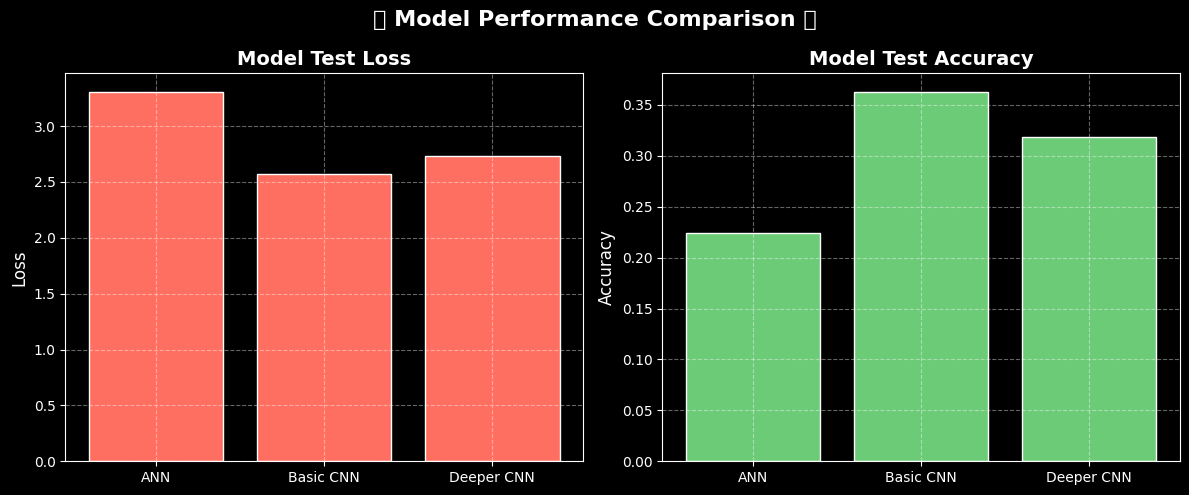

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

ann_model.load_weights('best_ann_model_weights.weights.h5')
basic_cnn_model.load_weights('best_basic_cnn_model_weights.weights.h5')
deeper_cnn_model.load_weights('best_deeper_cnn_model_weights.weights.h5')

loss_ann, accuracy_ann = ann_model.evaluate(test_images, test_labels_one_hot, verbose=0)
loss_basic_cnn, accuracy_basic_cnn = basic_cnn_model.evaluate(test_images, test_labels_one_hot, verbose=0)
loss_deeper_cnn, accuracy_deeper_cnn = deeper_cnn_model.evaluate(test_images, test_labels_one_hot, verbose=0)


import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['ANN', 'Basic CNN', 'Deeper CNN']
losses = [loss_ann, loss_basic_cnn, loss_deeper_cnn]
accuracies = [accuracy_ann, accuracy_basic_cnn, accuracy_deeper_cnn]

# Dark mode style
plt.style.use("dark_background")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loss plot
axes[0].bar(models, losses, color='#FF6F61', edgecolor='white')
axes[0].set_title('Model Test Loss', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.4)

# Accuracy plot
axes[1].bar(models, accuracies, color='#6BCB77', edgecolor='white')
axes[1].set_title('Model Test Accuracy', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.4)

# Overall title
plt.suptitle("✨ Model Performance Comparison ✨", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()


#### 4.2) Model Evaluation (Confusion Matrix & Report)

- Predict test images (ANN, Basic CNN, Deeper CNN)  
- Convert one-hot labels to integers  
- Get predicted labels with `argmax`  
- Print confusion matrix & classification report for each model


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


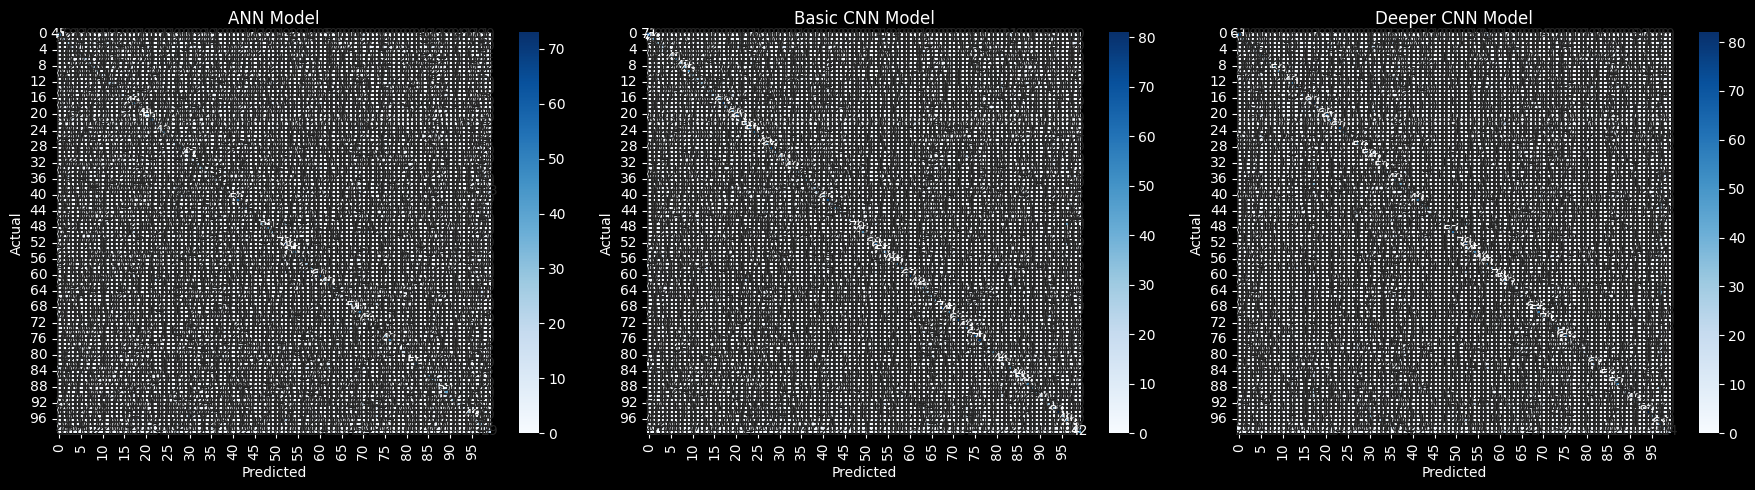

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predictions
ann_predictions = ann_model.predict(test_images)
basic_cnn_predictions = basic_cnn_model.predict(test_images)
deeper_cnn_predictions = deeper_cnn_model.predict(test_images)

# Convert labels
test_labels_int = np.argmax(test_labels_one_hot, axis=1)

ann_predicted_labels = np.argmax(ann_predictions, axis=1)
basic_cnn_predicted_labels = np.argmax(basic_cnn_predictions, axis=1)
deeper_cnn_predicted_labels = np.argmax(deeper_cnn_predictions, axis=1)

# Confusion matrices
cm_ann = confusion_matrix(test_labels_int, ann_predicted_labels)
cm_basic = confusion_matrix(test_labels_int, basic_cnn_predicted_labels)
cm_deeper = confusion_matrix(test_labels_int, deeper_cnn_predicted_labels)

# Plot side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(cm_ann, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("ANN Model")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_basic, annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_title("Basic CNN Model")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

sns.heatmap(cm_deeper, annot=True, fmt="d", cmap="Blues", ax=axes[2])
axes[2].set_title("Deeper CNN Model")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("Actual")

plt.tight_layout()
plt.show()

#### 4.3) Model Comparison

- Created a dataframe to store **test loss** and **test accuracy** for ANN, Basic CNN, and Deeper CNN.  
- Plotted training history for each model (accuracy & loss vs. epochs).  
- Helps compare how models learn and generalize over time.  

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

models = {
    "ANN": ("cyan", ann_history),
    "Basic CNN": ("magenta", basic_cnn_history),
    "Deeper CNN": ("yellow", deeper_cnn_history)
}

performance_data = {
    'Model': ['ANN', 'Basic CNN', 'Deeper CNN'],
    'Test Loss': [loss_ann, loss_basic_cnn, loss_deeper_cnn],
    'Test Accuracy': [accuracy_ann, accuracy_basic_cnn, accuracy_deeper_cnn]
}

performance_df = pd.DataFrame(performance_data)

fig = make_subplots(rows=1, cols=2, subplot_titles=('Accuracy', 'Loss'))

for name, (color, history) in models.items():
    # Accuracy
    fig.add_trace(go.Scatter(y=history.history['accuracy'], mode='lines',
                             name=name, line=dict(color=color, dash='solid')), row=1, col=1)
    fig.add_trace(go.Scatter(y=history.history['val_accuracy'], mode='lines',
                             name=name, line=dict(color=color, dash='dot'), showlegend=False), row=1, col=1)

    # Loss
    fig.add_trace(go.Scatter(y=history.history['loss'], mode='lines',
                             name=name, line=dict(color=color, dash='solid')), row=1, col=2)
    fig.add_trace(go.Scatter(y=history.history['val_loss'], mode='lines',
                             name=name, line=dict(color=color, dash='dot'), showlegend=False), row=1, col=2)

fig.update_layout(
    title_text="Model Comparison: Accuracy & Loss (Train=Solid, Val=Dot)",
    height=500,
    width=1200,
    template="plotly_dark"
)

fig.show()

#### 4.4) Predictions

This code:
- Uses the trained **Basic CNN model** to predict on test images.  
- Identifies **correctly** and **incorrectly** classified samples.  
- Randomly selects 100 correct and 100 incorrect predictions.  
- Displays them in a **20×10 grid**:  
  - ✅ Correct predictions → **Green title** (only predicted label).  
  - ❌ Incorrect predictions → **Red title** (Predicted vs True label).  


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


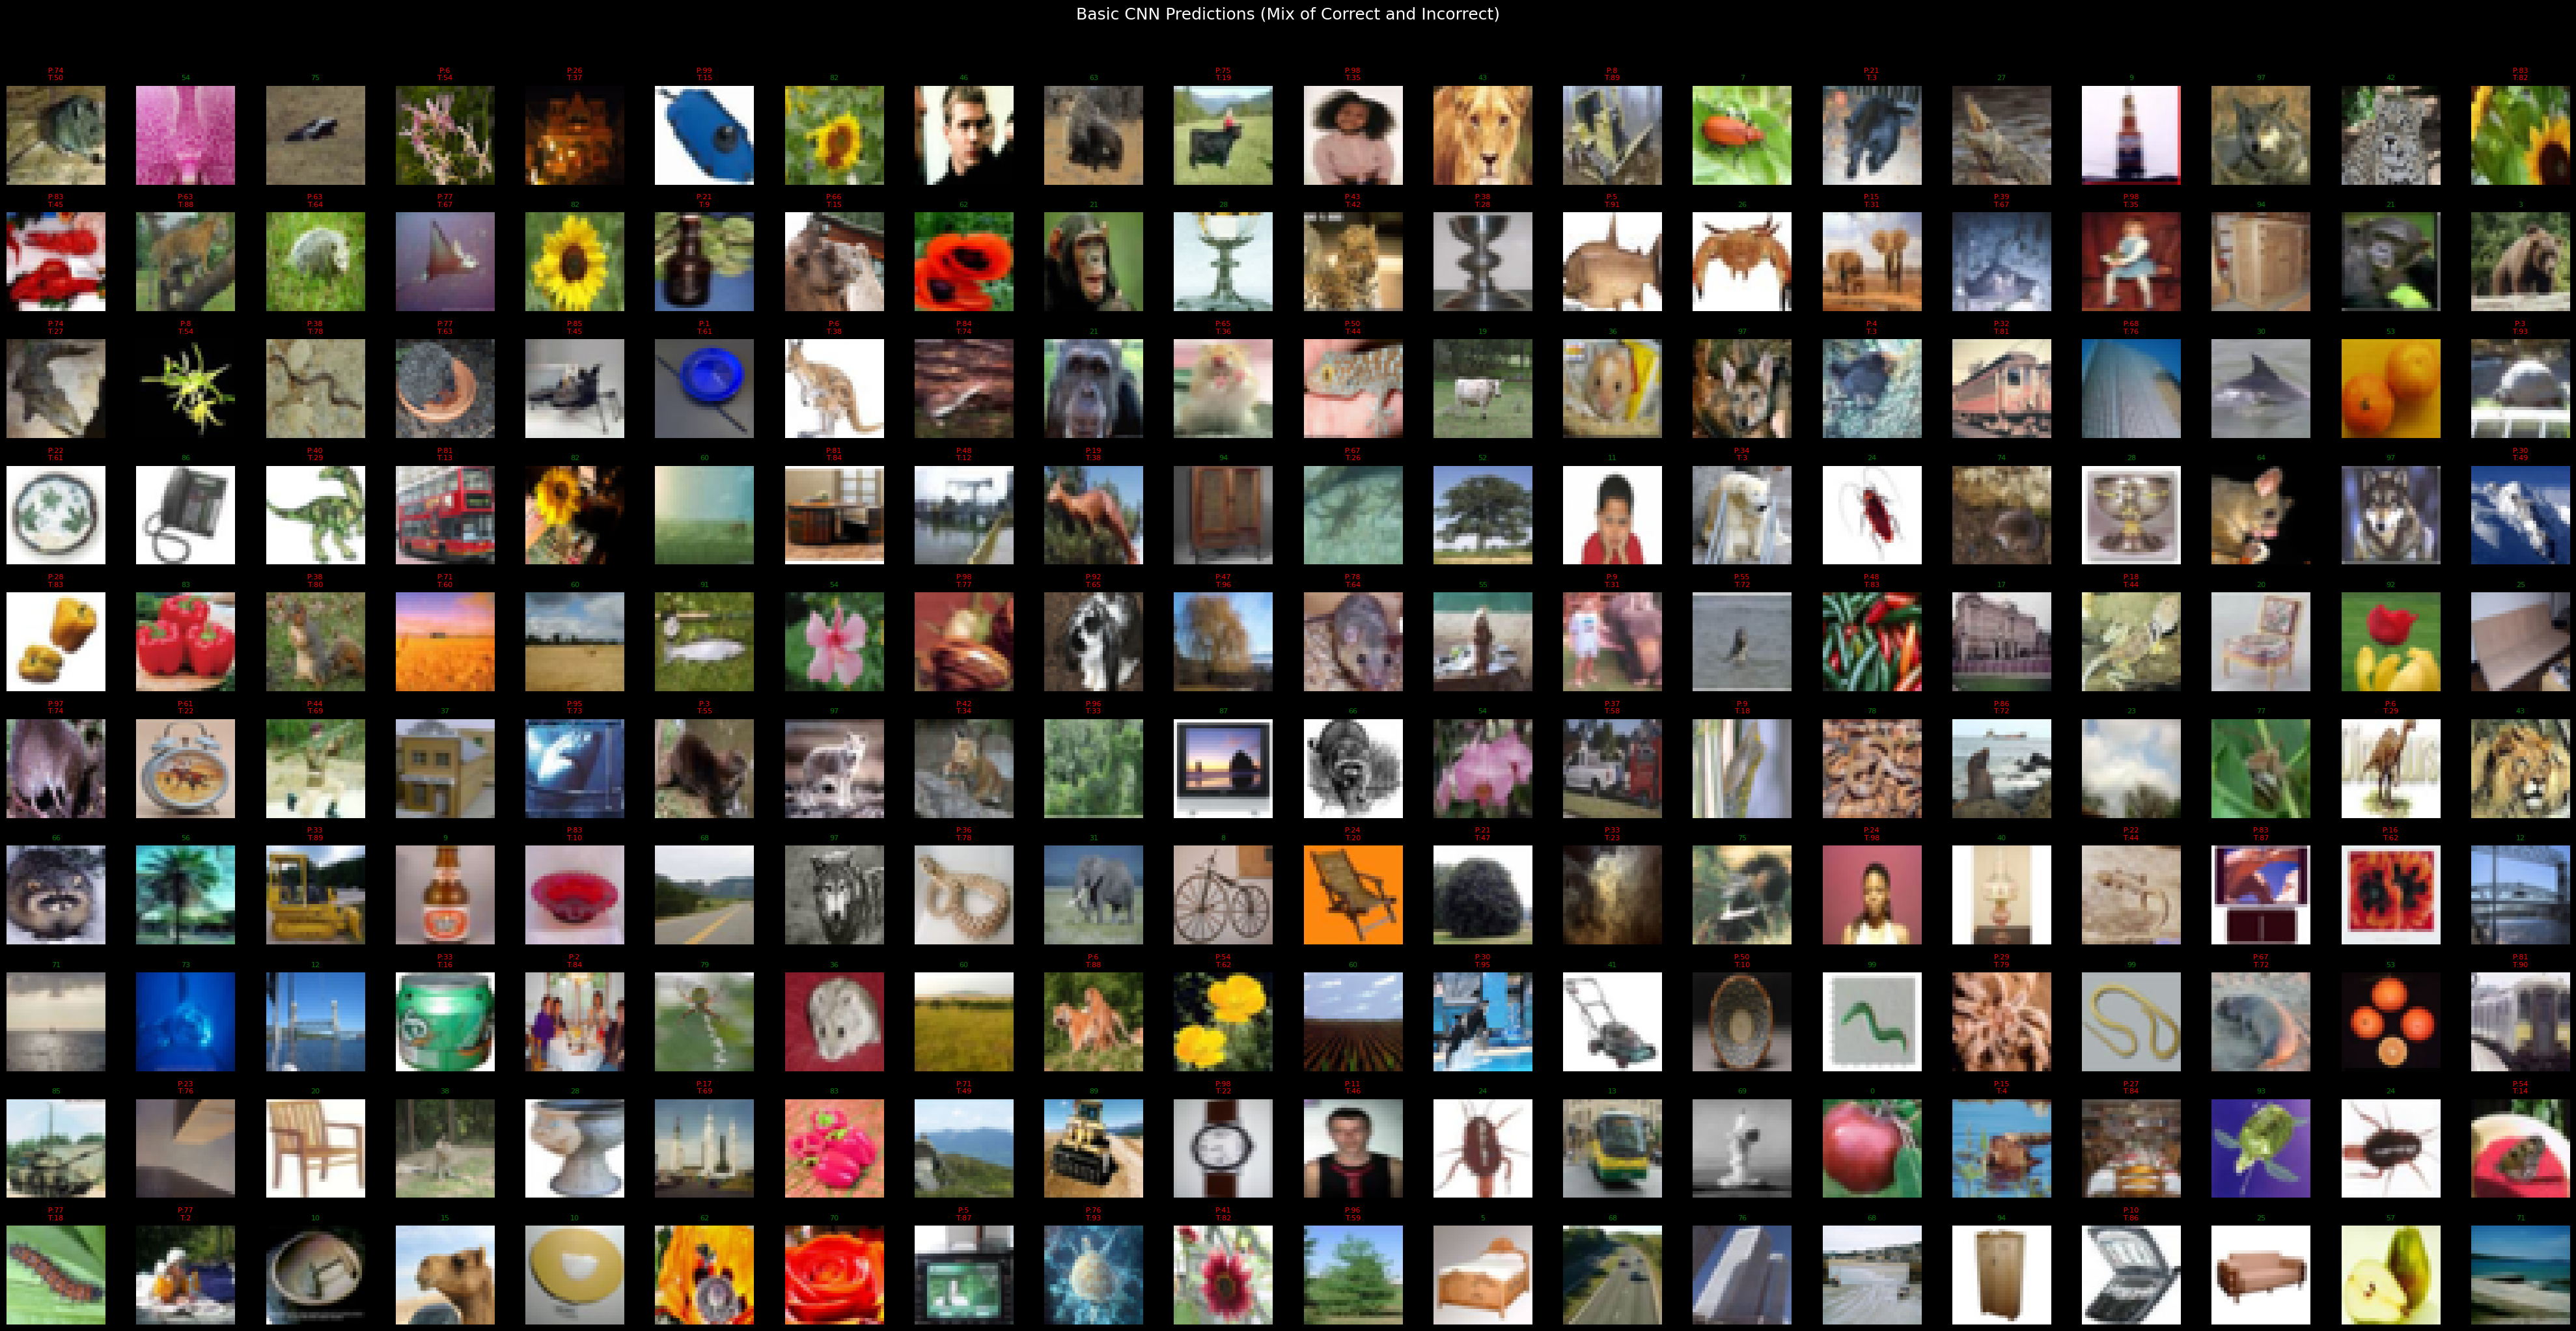

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Predictions
basic_cnn_predictions = basic_cnn_model.predict(test_images)
basic_cnn_predicted_labels = np.argmax(basic_cnn_predictions, axis=1)

# Flatten labels to match predicted shape
test_labels_flat = test_labels.flatten()

# Correct and incorrect indices
correctly_classified_indices = np.where(basic_cnn_predicted_labels == test_labels_flat)[0]
incorrectly_classified_indices = np.where(basic_cnn_predicted_labels != test_labels_flat)[0]

# Select some images to show
num_correct_to_show = min(100, len(correctly_classified_indices))
num_incorrect_to_show = min(100, len(incorrectly_classified_indices))

selected_correct_indices = np.random.choice(correctly_classified_indices, num_correct_to_show, replace=False)
selected_incorrect_indices = np.random.choice(incorrectly_classified_indices, num_incorrect_to_show, replace=False)

all_indices = np.concatenate((selected_correct_indices, selected_incorrect_indices))
np.random.shuffle(all_indices)

# Display images
num_cols = 20
num_rows = 10
fig, axes = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 * num_rows))
fig.suptitle("Basic CNN Predictions (Mix of Correct and Incorrect)", fontsize=18, y=1.02)

for i, idx in enumerate(all_indices[:num_rows*num_cols]):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].imshow(test_images[idx])
    
    pred = basic_cnn_predicted_labels[idx]
    true = test_labels_flat[idx]

    if pred == true:
        color = "green"
        title = f"{pred}"
    else:
        color = "red"
        title = f"P:{pred}\nT:{true}"

    axes[row, col].set_title(title, fontsize=8, color=color)
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()


Project Summary and Conclusion

This project focused on implementing and comparing three deep learning models—ANN, Basic CNN, and Deeper CNN—for image classification tasks using a benchmark dataset.

Summary of Work

Data Preparation:
The dataset was loaded, normalized, and one-hot encoded to prepare it for training with different model architectures. Images were reshaped as needed to match the input requirements of each model.

Model Development:
Three models of increasing complexity were designed:

Artificial Neural Network (ANN): Fully connected layers only.

Basic Convolutional Neural Network (CNN): Convolutional and pooling layers for feature extraction.

Deeper CNN: Additional convolutional layers, batch normalization, and dropout for improved generalization.

Model Training:
Each model was trained using the prepared data. Early Stopping and Model Checkpointing were applied to prevent overfitting and save the best-performing model weights.

Model Evaluation:
The models were evaluated on the test set using metrics such as loss and accuracy. Training histories were visualized, and confusion matrices were used to assess class-specific performance.

Prediction Analysis:
Predictions from the Basic CNN were visualized, showing both correctly and incorrectly classified images. This analysis helped identify patterns in the model’s strengths and weaknesses.

Key Findings

The Basic CNN generally achieved the best overall performance, balancing high accuracy with low validation loss.

The ANN performed moderately well but lagged behind both CNN architectures, highlighting the advantage of convolutional layers in extracting spatial features from images.

The Deeper CNN, despite its increased complexity, did not consistently outperform the Basic CNN. This suggests that for this dataset, additional layers and regularization may not have provided significant gains and could have introduced slight overfitting.

Conclusion

For this image classification task, a moderately complex CNN strikes the best balance between performance and efficiency. Convolutional layers effectively capture spatial patterns in the data, outperforming fully connected ANNs.

Future work could explore hyperparameter tuning, data augmentation, or alternative architectures (e.g., ResNet, EfficientNet) to further boost accuracy and generalization.